In [1]:
import torch
from torch import nn
from torchinfo import summary
from torchvision import models
from torchvision import transforms
from torchmetrics import Accuracy
from pathlib import Path
import os

import matplotlib.pyplot as plt

from timeit import default_timer as timer

from going_modular.going_modular import data_setup, engine, download_data, utils, evaluation

d:\Work\Coding\Machine-Learning\PyTorch\going_modular\going_modular\engine.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Device agnositc code

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Set accuracy metrics

In [3]:
train_accuracy_fn = Accuracy(task='multiclass', num_classes=3).to(device)
test_accuracy_fn = Accuracy(task='multiclass', num_classes=3).to(device)

## Let's load model parameters

In [4]:
weights = models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

## Create the transform functions

In [5]:
## Auto transform
auto_transform = weights.transforms()


# Manual tranform

normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
)

manual_transform = transforms.Compose([

    transforms.Resize((244, 244)),
    transforms.ToTensor(),
    normalize
])

auto_transform, manual_transform

(ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ),
 Compose(
     Resize(size=(244, 244), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ))

## Get number of cores

In [6]:
os.cpu_count()

12

In [7]:
dataset_path = Path('./datasets/pizza_steak_sushi')
train_dir = dataset_path / 'train'
test_dir = dataset_path / 'test'

## creat_dataloaders parameters

BATCH_SIZE = 32
NUM_WORKERS = 2

train_dataloader, test_dataloader, classes = data_setup.create_dataloaders(train_dir=train_dir,
                              test_dir=test_dir,
                              transform=auto_transform,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS)

train_dataloader, test_dataloader, classes

(<torch.utils.data.dataloader.DataLoader at 0x16b07f6f690>,
 ['pizza', 'steak', 'sushi'])

## Download the pertrained model

In [8]:
model = models.efficientnet_b0(weights=weights)
summary(model,
        input_size=[32, 3, 244, 244],
        col_names=['num_params', 'input_size', 'output_size', 'trainable'],
        row_settings=['var_names'])

Layer (type (var_name))                                      Param #                   Input Shape               Output Shape              Trainable
EfficientNet (EfficientNet)                                  --                        [32, 3, 244, 244]         [32, 1000]                True
├─Sequential (features)                                      --                        [32, 3, 244, 244]         [32, 1280, 8, 8]          True
│    └─Conv2dNormActivation (0)                              --                        [32, 3, 244, 244]         [32, 32, 122, 122]        True
│    │    └─Conv2d (0)                                       864                       [32, 3, 244, 244]         [32, 32, 122, 122]        True
│    │    └─BatchNorm2d (1)                                  64                        [32, 32, 122, 122]        [32, 32, 122, 122]        True
│    │    └─SiLU (2)                                         --                        [32, 32, 122, 122]        [32, 32, 122, 122]

## Freeze the features

In [9]:
for params in model.features.parameters():

    params.requires_grad = False

## Recreate the classfier

In [10]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(classes), bias=True)
)

In [11]:
summary(model,
        input_size=[32, 3, 244, 244],
        col_names=['num_params', 'input_size', 'output_size', 'trainable'],
        row_settings=['var_names'])

Layer (type (var_name))                                      Param #                   Input Shape               Output Shape              Trainable
EfficientNet (EfficientNet)                                  --                        [32, 3, 244, 244]         [32, 3]                   Partial
├─Sequential (features)                                      --                        [32, 3, 244, 244]         [32, 1280, 8, 8]          False
│    └─Conv2dNormActivation (0)                              --                        [32, 3, 244, 244]         [32, 32, 122, 122]        False
│    │    └─Conv2d (0)                                       (864)                     [32, 3, 244, 244]         [32, 32, 122, 122]        False
│    │    └─BatchNorm2d (1)                                  (64)                      [32, 32, 122, 122]        [32, 32, 122, 122]        False
│    │    └─SiLU (2)                                         --                        [32, 32, 122, 122]        [32, 32, 12

In [12]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## Create loss function and optimizer

In [13]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.01)

In [14]:
utils.set_seeds(SEED=42)
engine.fit_fn(model=model,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
            #   train_accuracy_fn=train_accuracy_fn,
            #   test_accuracy_fn=test_accuracy_fn,
              classes=classes,
              batch_size=BATCH_SIZE,
              epochs=5,
              device=device,
              experiment_name='auto_transform',
              model_name='effnetb0',
              extra='5_epochs')

[INFO] Created SummaryWriter, saving to: runs\24-02-2026\auto_transform\effnetb0\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

samples remaning: 0 / 256
samples remaning: 64 / 256
samples remaning: 128 / 256
samples remaning: 192 / 256
Train loss:  0.84560 --- | Train Accuracy:  54.67%


 20%|██        | 1/5 [00:23<01:33, 23.35s/it]

Test loss:  0.61118 --- | Test Accuracy:  68.00%
samples remaning: 0 / 256
samples remaning: 64 / 256
samples remaning: 128 / 256
samples remaning: 192 / 256
Train loss:  0.58165 --- | Train Accuracy:  83.11%


 40%|████      | 2/5 [00:44<01:06, 22.21s/it]

Test loss:  0.35262 --- | Test Accuracy:  92.00%
samples remaning: 0 / 256
samples remaning: 64 / 256
samples remaning: 128 / 256
samples remaning: 192 / 256
Train loss:  0.23407 --- | Train Accuracy:  92.44%


 60%|██████    | 3/5 [01:06<00:43, 21.85s/it]

Test loss:  0.42633 --- | Test Accuracy:  82.67%
samples remaning: 0 / 256
samples remaning: 64 / 256
samples remaning: 128 / 256
samples remaning: 192 / 256
Train loss:  0.43280 --- | Train Accuracy:  95.56%


 80%|████████  | 4/5 [01:27<00:21, 21.81s/it]

Test loss:  0.31972 --- | Test Accuracy:  86.67%
samples remaning: 0 / 256
samples remaning: 64 / 256
samples remaning: 128 / 256
samples remaning: 192 / 256
Train loss:  0.62204 --- | Train Accuracy:  90.22%


100%|██████████| 5/5 [01:49<00:00, 21.89s/it]

Test loss:  0.49880 --- | Test Accuracy:  80.00%
Total time taken on cuda is 1 min : 49.47905399999581 secs


## Getting data ready

### Download data

In [15]:
download_data.download_data(root="datasets/pizza_steak_sushi_20_percent",
                            source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")

datasets\pizza_steak_sushi_20_percent\pizza_steak_sushi directory exists


### data path

In [64]:
data_10_percent_path = Path('datasets/pizza_steak_sushi')
data_20_percent_path = Path('datasets/pizza_steak_sushi_20_percent/pizza_steak_sushi')

train_dir_10_percent = data_10_percent_path / 'train'
train_dir_20_percent = data_20_percent_path / 'train'

test_dir_10_percent = data_10_percent_path / 'test'
test_dir_20_percent = data_20_percent_path / 'test'

### Create DataLoaders

In [65]:
normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
)

data_transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
    normalize
])

BATCH_SIZE = 32
NUM_WORKERS = 2


train_dataloader_10_percent, test_dataloader_10_percent, classes = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                              test_dir=test_dir_10_percent,
                              transform=data_transform,
                              num_workers=NUM_WORKERS,
                              batch_size=BATCH_SIZE)

train_dataloader_20_percent, test_dataloader_20_percent, classes = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                              test_dir=test_dir_20_percent,
                              transform=data_transform,
                              num_workers=NUM_WORKERS,
                              batch_size=BATCH_SIZE)

train_dataloader_10_percent, train_dataloader_20_percent, test_dataloader_10_percent, classes

(<torch.utils.data.dataloader.DataLoader at 0x16bace22650>,
 ['pizza', 'steak', 'sushi'])

## Setup models

In [18]:
effnet_b0 = utils.create_effnetb0()
effnet_b2 = utils.create_effnetb2()

[INFO] Created new effnetb0 model
[INFO] Created new effnetb2 model


In [19]:
summary(effnet_b0,
        input_size=[32, 3, 244, 244],
        col_names=['num_params', 'input_size', 'output_size', 'trainable'],
        row_settings=['var_names'])

Layer (type (var_name))                                      Param #                   Input Shape               Output Shape              Trainable
EfficientNet (EfficientNet)                                  --                        [32, 3, 244, 244]         [32, 3]                   Partial
├─Sequential (features)                                      --                        [32, 3, 244, 244]         [32, 1280, 8, 8]          False
│    └─Conv2dNormActivation (0)                              --                        [32, 3, 244, 244]         [32, 32, 122, 122]        False
│    │    └─Conv2d (0)                                       (864)                     [32, 3, 244, 244]         [32, 32, 122, 122]        False
│    │    └─BatchNorm2d (1)                                  (64)                      [32, 32, 122, 122]        [32, 32, 122, 122]        False
│    │    └─SiLU (2)                                         --                        [32, 32, 122, 122]        [32, 32, 12

In [20]:
summary(effnet_b2,
        input_size=[32, 3, 244, 244],
        col_names=['num_params', 'input_size', 'output_size', 'trainable'],
        row_settings=['var_names'])

Layer (type (var_name))                                      Param #                   Input Shape               Output Shape              Trainable
EfficientNet (EfficientNet)                                  --                        [32, 3, 244, 244]         [32, 3]                   Partial
├─Sequential (features)                                      --                        [32, 3, 244, 244]         [32, 1408, 8, 8]          False
│    └─Conv2dNormActivation (0)                              --                        [32, 3, 244, 244]         [32, 32, 122, 122]        False
│    │    └─Conv2d (0)                                       (864)                     [32, 3, 244, 244]         [32, 32, 122, 122]        False
│    │    └─BatchNorm2d (1)                                  (64)                      [32, 32, 122, 122]        [32, 32, 122, 122]        False
│    │    └─SiLU (2)                                         --                        [32, 32, 122, 122]        [32, 32, 12

## Training

In [21]:
num_epochs = [5, 10]

models = ['effnet_b0', 'effnet_b2']

train_dataloaders = {
    'data_10_percent': train_dataloader_10_percent,
    'data_20_percent': train_dataloader_20_percent
}

In [23]:
# start_time = timer()

# experiments = 0

# for epochs in num_epochs:

#     for dataloader_name, dataloader in train_dataloaders.items():

#         for model_name in models:

#             experiments += 1
#             print(f"[INFO] Experminet number: {experiments}")
#             print(f"[INFO] Model: {model_name}")
#             print(f"[INFO] Dataloader: {dataloader_name}")
#             print(f"[INFO] Number of epochs: {epochs}")

#             if model_name == "effnet_b0":
#                 model = utils.create_effnetb0()
#             elif model_name == "effnet_b2":
#                 model = utils.create_effnetb2()

#             ## Create loss function and optimizer

#             loss_fn = nn.CrossEntropyLoss()

#             optimizer = torch.optim.Adam(params=model.parameters(),
#                                     lr=0.001)

#             engine.fit_fn(model=model,
#                           train_dataloader=dataloader,
#                           test_dataloader=test_dataloader_10_percent,
#                           loss_fn=loss_fn,
#                           optimizer=optimizer,
#                           classes=classes,
#                           batch_size=BATCH_SIZE,
#                           epochs=epochs,
#                           device=device,
#                           experiment_name=dataloader_name,
#                           model_name=model_name,
#                           extra=f"{epochs}_epochs")
            
#             MODEL_SAVE_PATH = f"models"
#             MODEL_NAME = f"{experiments+9}-{model_name}-{dataloader_name}-{epochs}-epochs"

#             utils.save_model(model=model,
#                              target_dir=MODEL_SAVE_PATH,
#                              model_name=MODEL_NAME)
            
#             print("\n\n" + "-"*60 + "\n\n")

# end_time = timer()

# utils.print_train_time(start=start_time,
#                        end=end_time,
#                        device=device)

In [24]:
best_model_path = 'models/17_effnet_b2_data_20_percent_10_epochs.pt'

best_model = utils.create_effnetb2()

best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model


<All keys matched successfully>

In [34]:
model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


## Plot predictions

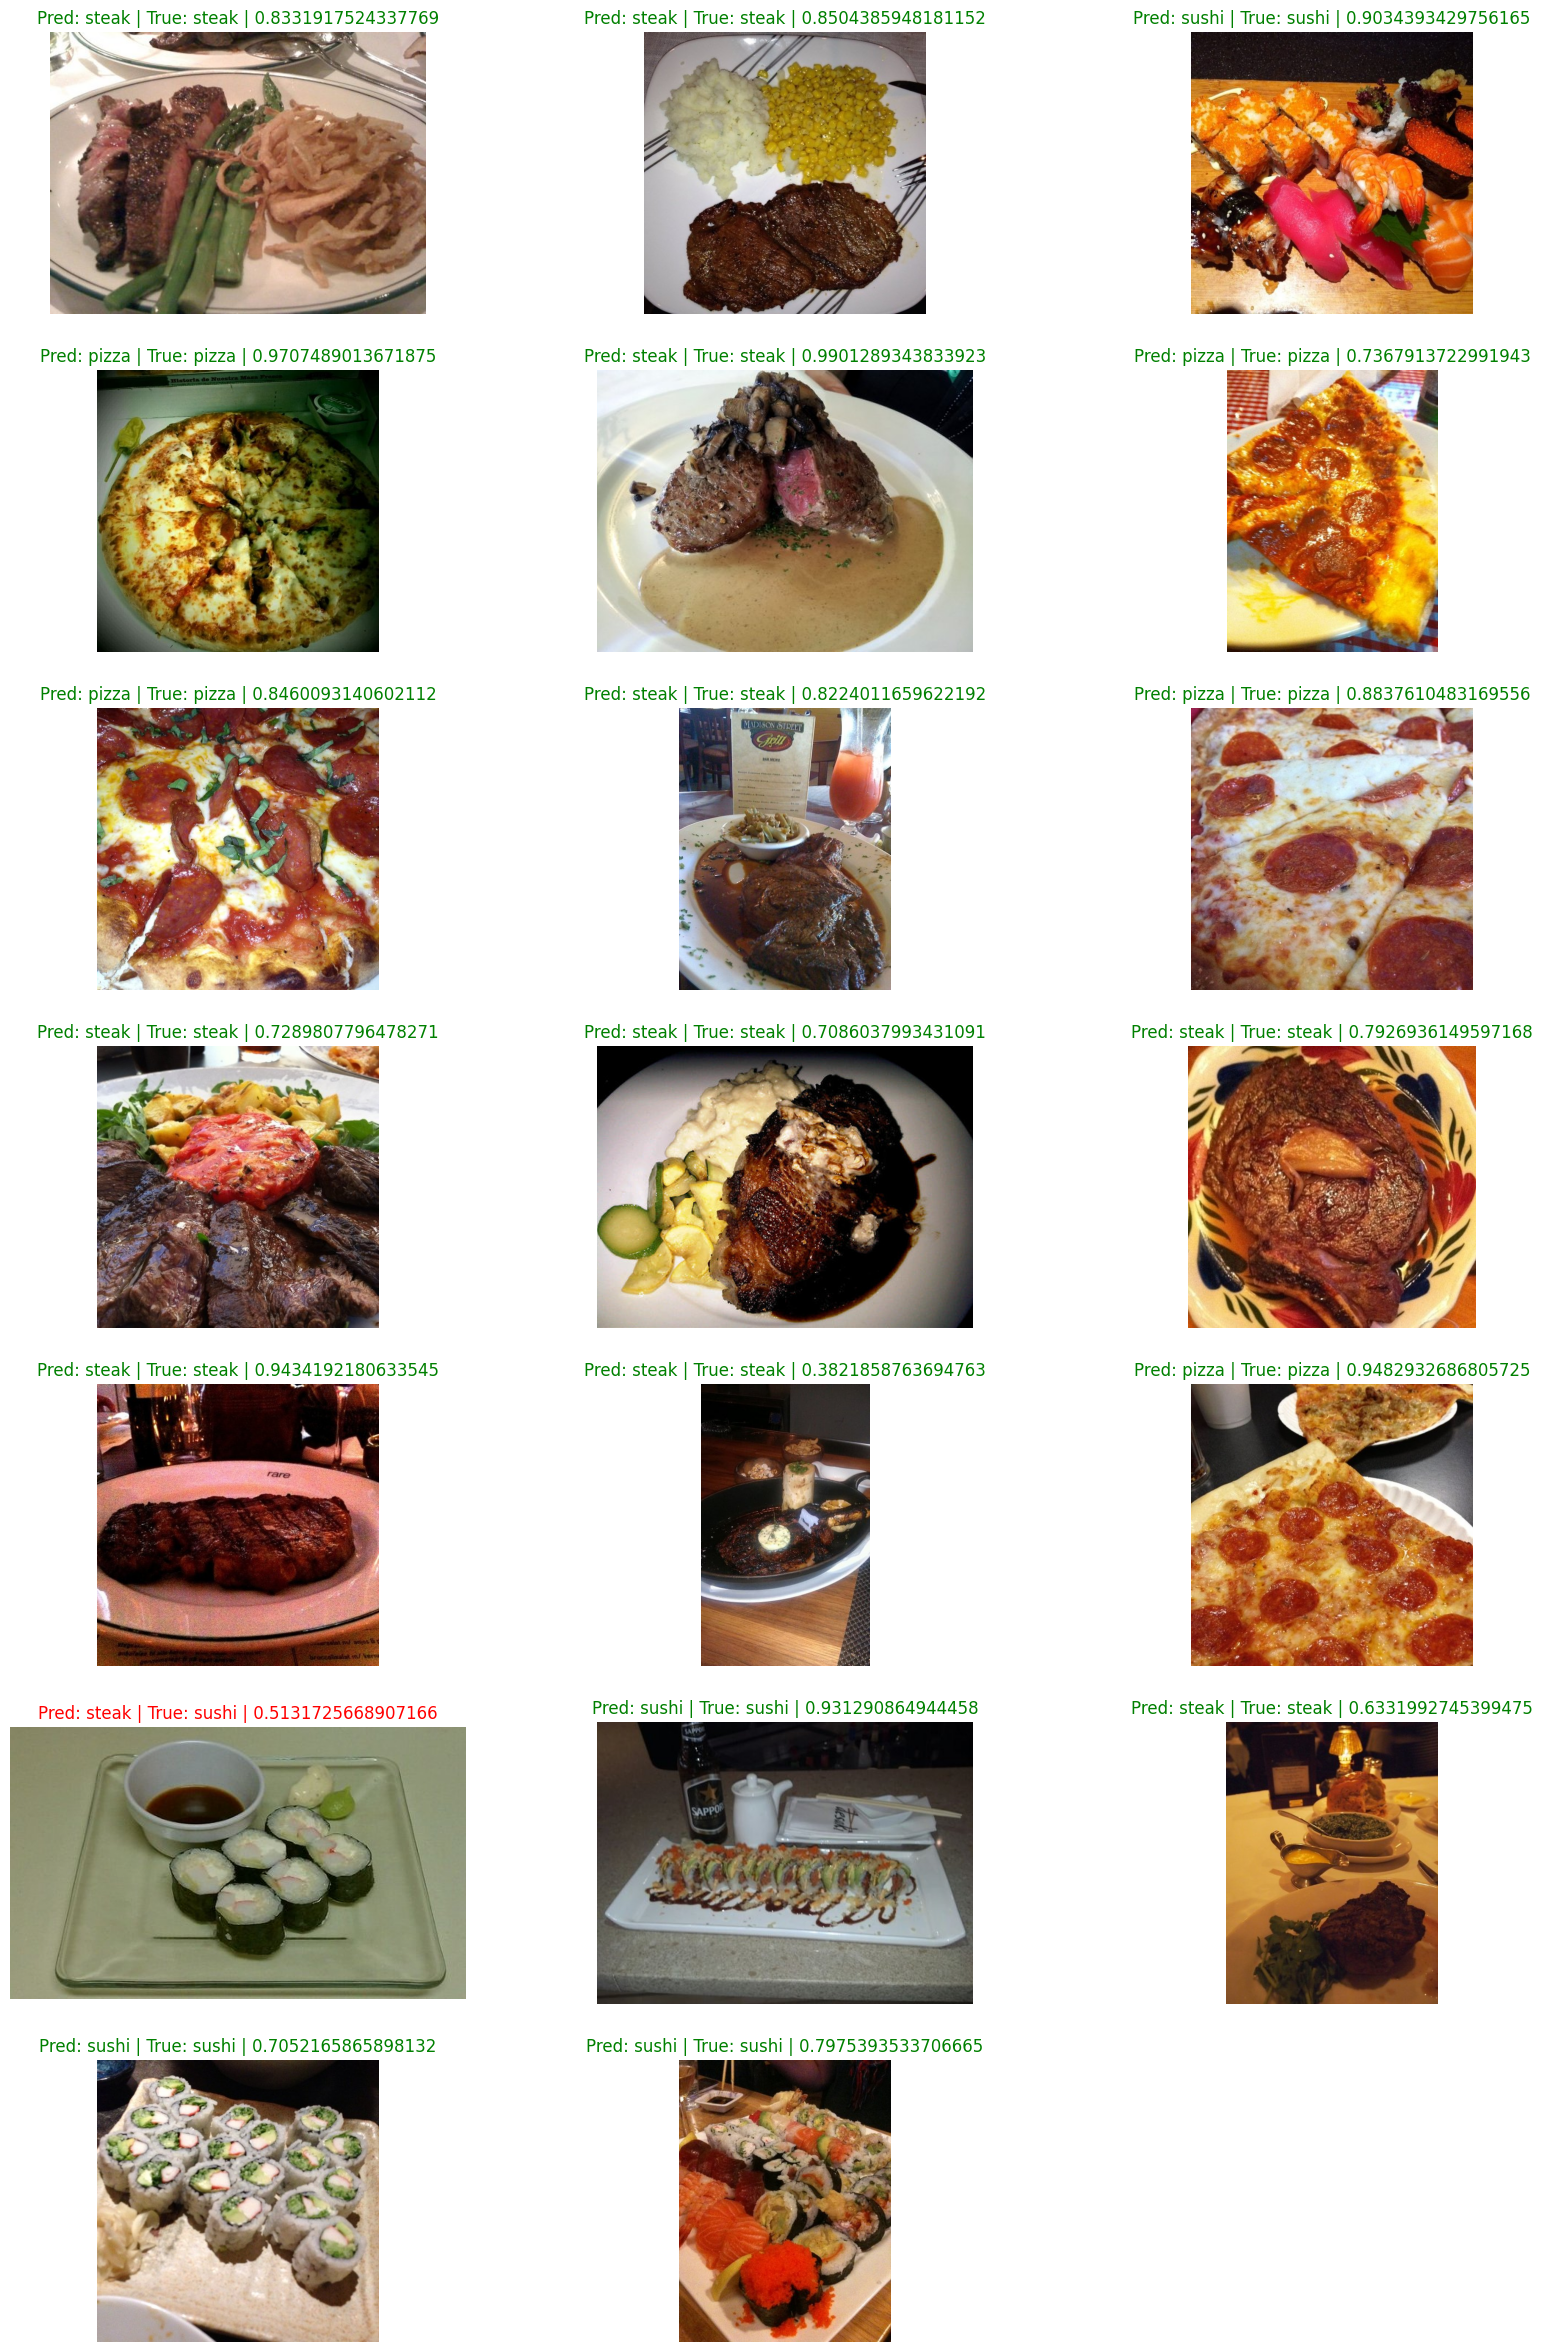

In [ ]:
image_path_list = list(test_dir_20_percent.glob('*/*.jpg'))

utils.plot_predictions(model=best_model,
                            image_path_list=image_path_list,
                            transform=data_transform,
                            k=20,
                            classes=classes,
                            device=device)

## Predict on our own data

In [78]:
custom_image_path = Path('datasets/pizza-dad.jpeg')
custom_image = Image.open(custom_image_path)
custom_image = data_transform(custom_image)
custom_image

tensor([[[ 0.4851,  0.1768,  0.3823,  ..., -1.8610, -1.8439, -1.8268],
         [ 1.1015,  1.0502,  0.9988,  ..., -1.8782, -1.8268, -1.8268],
         [-1.1932, -1.1418, -1.0562,  ..., -1.8610, -1.8268, -1.8439],
         ...,
         [-0.9705, -1.0219, -1.0562,  ...,  0.2111, -0.0458, -0.1828],
         [-1.0048, -1.0390, -1.0733,  ...,  0.6221,  0.5536,  0.2967],
         [-1.0390, -1.0562, -1.0733,  ...,  0.6392,  0.6221,  0.5364]],

        [[ 0.7129,  0.3978,  0.5903,  ..., -1.7381, -1.7031, -1.7031],
         [ 1.3606,  1.2906,  1.2381,  ..., -1.7556, -1.6856, -1.6681],
         [-1.0203, -0.9853, -0.8978,  ..., -1.7381, -1.6681, -1.6681],
         ...,
         [-1.2654, -1.2654, -1.2829,  ..., -0.3901, -0.5826, -0.6702],
         [-1.2479, -1.2829, -1.3004,  ..., -0.1275, -0.1625, -0.3375],
         [-1.2654, -1.2829, -1.2829,  ..., -0.0924, -0.1099, -0.1975]],

        [[ 0.6879,  0.3742,  0.5311,  ..., -1.6127, -1.5779, -1.5779],
         [ 1.6291,  1.5594,  1.4722,  ..., -1

In [83]:
custom_image_path = Path('datasets/pizza-dad.jpeg')
custom_image = Image.open(custom_image_path)
transformed_custom_image = data_transform(custom_image)

pred, confidence = evaluation.make_predictions(model=best_model,
                            image=transformed_custom_image,
                            classes=classes,
                            device=device)

(np.float64(-0.5), np.float64(3023.5), np.float64(4031.5), np.float64(-0.5))

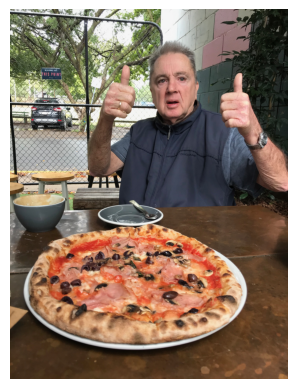

In [87]:
plt.imshow(custom_image)
plt.axis(False)